## Amazon Fine Food Reviews Analysis: 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  Id
2.  ProductId - unique identifier for the product
3.  UserId - unqiue identifier for the user
4.  ProfileName
5.  HelpfulnessNumerator - number of users who found the review helpful
6.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7.  Score - rating between 1 and 5
8.  Time - timestamp for the review
9.  Summary - brief summary of the review
10. Text - text of the review

The dataset is available in two forms

  1.  .csv file
  2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation will be set to "positive". Otherwise, it will be set to "negative

## Importing the necessary Libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")
import math
import os
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn import datasets, neighbors
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit

In [42]:
import sqlite3
con = sqlite3.connect('/content/drive/My Drive/database.sqlite')

filtered_data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""",con)

filtered_data.shape
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [44]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 1]
finalp = finalp.sample(frac=0.16,random_state=1)

finaln = final[final.Score == 0]
finaln = finaln.sample(frac=0.4,random_state=1) 

final = pd.concat([finalp,finaln],axis=0)

#sorting data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(71974, 10)


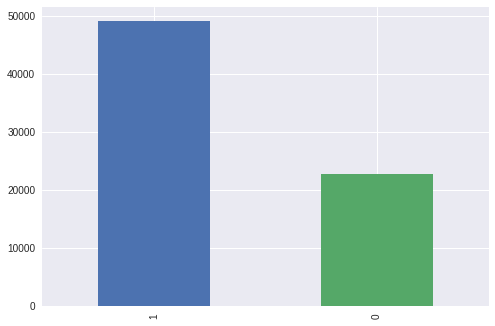

In [45]:
final['Score'].value_counts().plot(kind='bar')

In [46]:
%timeit
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Naive Bayes Model using Different Featurization Techniques

#### Bag of Words

In [0]:
X = final_string

y = final['Score']


X_train =  final_string[0:50000] 

X_test = final_string[50000:71950]

y_train = y[0:50000]

y_test =  y[50000:71950]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
final_bow_count1 = count_vect.fit_transform(X_train)
final_bow_count2 = count_vect.transform(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler(with_mean=False).fit_transform(final_bow_count1)
X_test = StandardScaler(with_mean=False).fit_transform(final_bow_count2)

#### Function to compute alpha values

In [0]:
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(0.0001, 1000, 10)
       
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'f1')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha


The optimal number of alpha is 890.


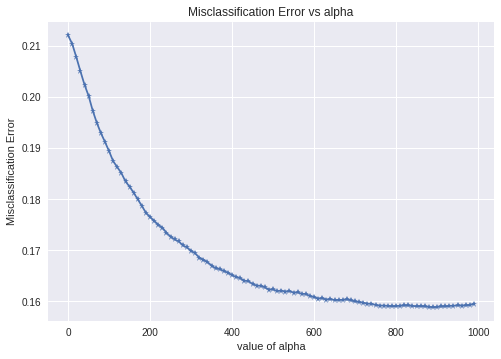

890.0001

In [88]:

optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [0]:
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

nb_optimal.fit(X_train, y_train)
pred = nb_optimal.predict(X_test)

In [0]:
bow_features = count_vect.get_feature_names()

In [91]:
feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 27639)

In [92]:
nb_optimal.class_count_

array([15280., 34720.])

In [93]:

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-10.46708153, -10.46708153, -10.46708153, ..., -10.24294161,
        -10.46708153, -10.46708153],
       [-10.43969971, -10.43969971, -10.43969971, ..., -10.66383962,
        -10.43969971, -10.37334799]])

In [94]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(27639, 2)

#### Top 10 feature from both class(Feature Importance)

In [95]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

('Top 10 Negative Features:-\n', tast         -7.882223
like         -7.975842
product      -8.032671
would        -8.098040
disappoint   -8.121254
one          -8.176085
tri          -8.198637
buy          -8.226320
even         -8.288102
bad          -8.290924
Name: 0, dtype: float64)
('\n\n Top 10 Positive Features:-\n', great    -7.458585
love     -7.477150
good     -7.536262
like     -7.632915
tast     -7.685659
use      -7.747035
tri      -7.755665
make     -7.755752
one      -7.765606
flavor   -7.774364
Name: 1, dtype: float64)


In [113]:
# evaluate f1 score on test data
f1_bow = f1_score(y_test, pred)*100
print('\nThe f1 score of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, f1_bow))


The f1 score of the naive bayes classifier for alpha = 890 is 83.138159%


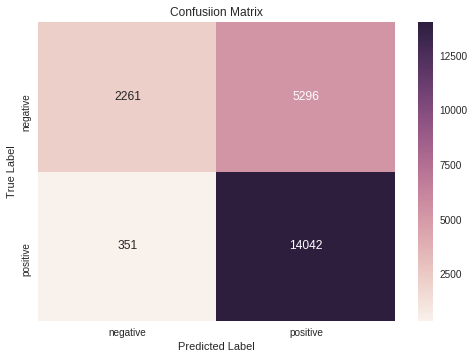

In [97]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:

1. The top features of BOW vector has been visualised.
2. The F1 score of 0.831 has been achieved for this featurization technique.
3. The optimal number of alpha is found to be 890 from Misclassification error vs alpha value plot.

#### TF-IDF Vectorization

In [0]:
X = final_string

y = final['Score']


X_train =  final_string[0:50000] 

X_test = final_string[50000:71950]

y_train = y[0:50000]

y_test =  y[50000:71950]

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

final_tfidf_count1 = tf_idf_vec.fit_transform(X_train)
final_tfidf_count2 = tf_idf_vec.transform(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_count1)
X_test = StandardScaler(with_mean=False).fit_transform(final_tfidf_count2)


The optimal number of alpha is 980.


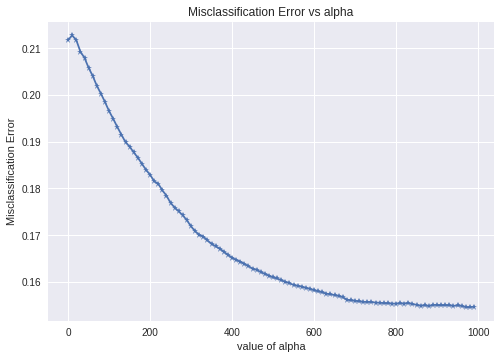

980.0001

In [104]:
optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

In [0]:
nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)
nb_optimal.fit(X_train, y_train)

pred = nb_optimal.predict(X_test)

In [109]:
tfidf_features = tf_idf_vec.get_feature_names()

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 27639)

In [110]:
log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-10.43598322, -10.43598322, -10.43598322, ..., -10.23045596,
        -10.43598322, -10.43598322],
       [-10.41648062, -10.41648062, -10.41648062, ..., -10.62200788,
        -10.41648062, -10.34234223]])

In [111]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(27639, 2)

#### Top 10 feature from both class(Feature Importance)

In [112]:
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

('Top 10 negative features:-\n', tast         -7.926879
like         -8.020419
product      -8.144404
would        -8.166557
disappoint   -8.233790
one          -8.260240
tri          -8.297550
dont         -8.359254
flavor       -8.381634
even         -8.387156
Name: 0, dtype: float64)
('\n\n Top 10 positive features:-\n', love     -7.554406
great    -7.557808
good     -7.602512
like     -7.656080
tast     -7.699286
use      -7.736116
flavor   -7.745863
make     -7.782685
one      -7.783175
tri      -7.809281
Name: 1, dtype: float64)


In [114]:
f1_tfidf = f1_score(y_test, pred) * 100
print('\nThe f1 score of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, f1_tfidf))


The f1 score of the naive bayes classifier for alpha = 980 is 83.138159%


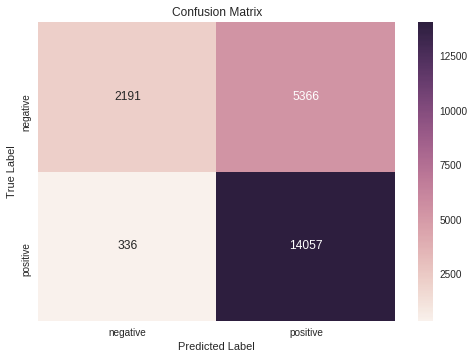

In [115]:
cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observations:

1. The top features of tfidf vector has been visualised.
2. The F1 score of 0.831 has been achieved for this featurization technique.
3. The optimal number of alpha is found to be 980 from Misclassification error vs alpha value plot.

In [3]:
import pandas as pd
models = pd.DataFrame({'Model': ['BOW', "TFIDF"],
                       'Hyper Parameter(K)': [890, 980],
                       'F1 score': [0.831, 0.831]}, 
                        columns = ["Model", "Hyper Parameter(K)", "F1 score"])
                       
models

,Model,Hyper Parameter(K),F1 score
0,BOW,890,0.831
1,TFIDF,980,0.831
